# Assignment 3 Autoencoder and GAN

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# problem 1 gradient

In problem set 1, we found solutions to least-squares regression using the closed form solution to

$$
\left\|Xw-y \right\|_2^2
$$

Where $X$ is the data, $y$ is the targets, and $w$ are the weights/coefficients. 

Sometimes when developing a model, it may be a good idea to check that the gradients determined by PyTorch are what we expect. 

We will now do this in a linear regression setting.

## calculate gradient

show that gradient of squared loss w.r.t to weight $w$ is
 
$$
\nabla_w\left\|Xw-y \right\|_2^2 = 2X^TXw − 2X^T y
$$


\begin{align}
\nabla_{w}\|X w-y\|_{2}^{2}&=\frac{\partial}{\partial w}(X w-y)^{\top}(X w-y)
\\&=\frac{\partial}{\partial w}\left(w^{\top} X^{\top} X w-(X w)^{\top} y-y^{\top} X w+y^{\top} y\right)
\\&=\frac{\partial}{\partial w}\left(w^{\top} X^{\top} X w-2 w^{\top} X^{\top} y+y^{\top} y\right)
\\&=2 X^{\top} X w-2 X^{\top} y
\end{align}


## PyTorch autograd

Using PyTorch’s autograd functionality, check that the gradient (at the initial weights) with respect to w is the same as what we expect from the closed form solution of the gradient above. 

In [2]:
# import sample data
housing = fetch_california_housing(data_home="data")
m, n = housing.data.shape

X = torch.Tensor(housing["data"]) # [20640, 8]
y = torch.Tensor(housing["target"]).unsqueeze(1) # [20640, 1]
# create the weight vector
w_init = torch.randn(8, 1, requires_grad=True)

# a) calculate closed form gradient with respect to the weights
grad_w1 = 2 * X.T @ X @ w_init - 2 * X.T @ y

# b) calculate gradient with respect to the weights w using autograd
# squared loss function
loss = torch.pow((X @ w_init - y), 2).sum()

# backpropagation
loss.backward()

# retrive gradient of weight
grad_w2 = w_init.grad

# c) check that the two are equal
print(torch.allclose(grad_w1, grad_w2, rtol=1e-05, atol=1e-08, equal_nan=False)) # True

True


I use `torch.allclose()` method to check if analytical gradient and autograd gradient are the same with absolute tolerance $10^{-8}$ and relative tolerance $10^{-5}$，the result is that they are the same.

# problem 2 gradient descent

## obstables of gradient descent

It’s tempting to use gradient descent to try to learn good values for hyper-parameters such as $\lambda$ and $\eta$. 

1. Can you think of an obstacle to using gradient descent to determine $\lambda$ ?

    we don't know how to compute $\frac{\partial w_i}{\partial \lambda}$


2. Can you think of an obstacle to using gradient descent to determine $\eta$?

    loss function isn't a function of $\eta$, so we can't compute gradient of cost function w.r.t $\eta$


- Suppose we learn weights $w_{\lambda}$ on the training set

$$
w_{\lambda} = \arg \min_w \left\| y - X w\right\|_2^2 + \lambda \left\| w\right\|_2^2
$$

- we want to find $\lambda$ minimizes error on the validation set

$$
\lambda = \arg \min_{\lambda}\left\|\tilde y - \tilde X w\right\|_2^2 
$$

- take gradient of validation loss w.r.t $\lambda$

$$
\frac{\partial L(\lambda)}{\partial \lambda} = \frac{\partial \left\| \tilde y - \tilde X w_{\lambda}\right\|}{\partial \lambda} = -2(\tilde y - \tilde X w_{\lambda})^T \tilde X \frac{\partial w_{\lambda}}{\partial \lambda}
$$

- But we don't know how to compute $\frac{\partial w_i}{\partial \lambda}$, that's an obstacle


- except for Ridge regression, it has a closed form solution, the final weight is

$$
w_{\lambda} = (X^TX+\lambda I)^{-1} X^T y
$$


- and gradient of final weight w.r.t $\lambda$ is

$$
\frac{\partial w_{\lambda} }{\partial \lambda} = \frac{\partial}{\partial \lambda}(X^TX+\lambda I)^{-1} X^T y= (X^TX+\lambda I)^{-2} X^T y
$$


- plug $\frac{\partial w_{\lambda} }{\partial \lambda}$, we have

$$
\frac{\partial L(\lambda)}{\partial \lambda} =  -2\left[\tilde y - \tilde X (X^T X + \lambda I) X^T y\right]^T \tilde X (X^T X + \lambda I)^{-2} X^T y
$$

References:

https://stats.stackexchange.com/questions/301034/gradient-descent-to-optimize-regularization-parameter-lambda-instead-of-doing

https://cs.stackexchange.com/questions/74561/what-are-the-challenges-of-using-gradient-descent-on-hyper-parameters-%CE%BB-and-%CE%B7-to

## L2 regularization

L2 regularization sometimes automatically similar to weight initialization by $N(0, \frac{1}{\sqrt{n_{in}}})$, where $n_{in}$ is the number inputs to a neuron

Suppose we are using the old approach to weight initialization by $N(0, 1)$

Sketch a heuristic argument that:

### (a)	Supposing λ is not too small, the first epochs of training will be dominated almost entirely by weight decay.

$$C=C_{0}+\frac{\lambda}{2 n} \sum_{w} w^{2}$$

where $C_0$ is the original, unregularized cost function. 

When $\lambda$ is not too small, the second term dominates the cost function. Therefore, the first epochs of training will be dominated almost entirely by weight decay. 

### (b)	Provided $\eta\lambda \ll n$, the weights will decay by a factor of $\exp(-\frac{\eta\lambda}{m})$ per epoch, where n is training size, and m is mini-batch size

- Given SGD update rule, 

$$
w \rightarrow\left(1-\frac{\eta \lambda}{n}\right) w-\frac{\eta}{m} \sum_{x} \frac{\partial C_{x}}{\partial w}
$$.


- Since $\left(1-\frac{\eta \lambda}{n}\right) \in [0,1]$, the weight will decay every mini-batch. 


- The weight can decay $\frac{n}{m}$ times in an epoch, so the weight will decay by $\left(1-\frac{\eta \lambda}{n}\right) ^ \frac{n}{m}$ in an epoch.

- Given $\underset{n \to \infty}{\lim}\left(1-\frac{1}{n}\right)^{n}=e^{-1}$.

$$
\lim_{\frac{n}{\eta \lambda}\to \infty}\left(1-\frac{\eta \lambda}{n}\right)^{\frac{n}{m}} = \left(1-\frac{\eta \lambda}{n}\right)^{\left(-\frac{n}{\eta \lambda}\right) \left(-\frac{\eta \lambda}{m}\right)} = e^{-\frac{\eta \lambda}{m}}
$$

### (c)	Supposing $\lambda$ is not too large, the weight decay will gradually diminish when the weights are down to a size around $\frac{1}{\sqrt{n}}$, where n is the total number of weights in the network.

Suppose we initialize the $n$ weights using mean 0 and standard deviation 1. The output will have standard deviation $\sqrt{n}$. If we use sigmiod function as activation, the neuron will saturate and the gradient will vanish. 

When $\lambda$ is not too large, when the weights shrink to some specific point, the neurons become not saturated, the gradient of loss function will dominate the gradient of regularization term, there is a point where weight decay tails off.

we can assume all the input neuron are 1 and the standard deviation of the weights is $\sigma$. Then the variance of output neuron is $n\sigma^2$, its standard deviation is $\sqrt{n\sigma^2}$. 

When we need unsaturated neurons, we want the output neuron to have the same scale as the input neuron, i.e. 1, which is within the range of the sigmoid function where the gradient is not zero. 

$$
\sqrt{n\sigma^2} = 1 \Rightarrow  \sigma = \frac{1}{\sqrt{n}}
$$

# problem 3 Autoencoder

## prevent learning identity function

Autoencoders learn to recreate their input after passing it through a sequence of layers in a neural network. 

This goal can be satisfied by simply learning the identity function. 

What design choices can be made (e.g. about the network architecture) to prevent them from learning the identity function? 

Pick at least two and discuss why an autoencoder with your design choice would be more useful than one without it.

(1) Restrict the size of bottleneck layer to be much smaller than input: force the encoder only learn useful features from input rather than keep all the features.  

(2) Add regularization to cost function: regularization will prevent the Autoencoder from overfitting noise and the cost function will not achieve minimum when output is perfectly equal to input.

## denoising autoencoder

denoising autoencoders learn to correct a corruption process $C(\hat x|x)$.  

Describe an example of such a corruption process, express it in a formula, and provide a plot of an original 2D dataset (e.g. samples from $y = x^2$) and the same dataset after you’ve corrupted it with your function $C$

The formula I choose is $y=x^3$. I corrupt it using random Gaussian noise.

The corrupted data is $y=x^3 + \epsilon$ where $\epsilon \sim N(0,1)$. 

The blue dots are samples from the original dataset and the red dots are samples from the corrupted dataset.

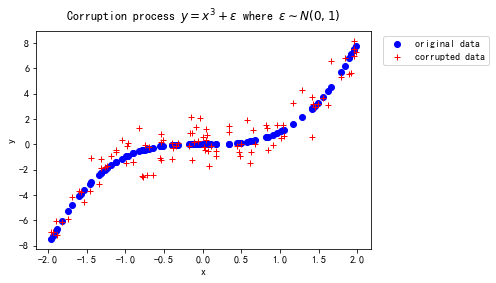

In [6]:
x = np.random.uniform(-2,2,100)
y = x ** 3
noise = np.random.normal(0, 1, 100)
corrupted_y = y + noise
plt.plot(x, y, 'bo',label="original data") 
plt.plot(x, corrupted_y, 'r+',label="corrupted data")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left") 
plt.title("Corruption process $y=x^3 + \epsilon$ where $\epsilon \sim N(0,1)$"
         , y=1.02)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Build an autoencoder

Build an autoencoder that embeds the MNIST dataset into 2D 

a good baseline is an encoder that uses three layers to compress the images into two dimensions, followed by a three-layer decoder that undoes this compression.

After you’ve trained your model and have obtained reasonable reconstruction accuracy, obtain the 2- dimensional embeddings of a batch of images, and plot with colors indicating the label of each image. 

Describe what you can learn about this dataset from looking at the points embedded into the latent space of the autoencoder.

My Autoencoder architecture: Both encoder and decoder have 4 layers with a tanh activation between each linear layer. The shape of each layer is 784-1000-500-250-2-250-500-1000-784. Use sigmoid activation function on output of the last hidden layer.

- optimizer is Adam

- reconstruction loss is mean squared error

- hyperparameters: batch size = 128, number of epochs = 100, learning rate = 0.001



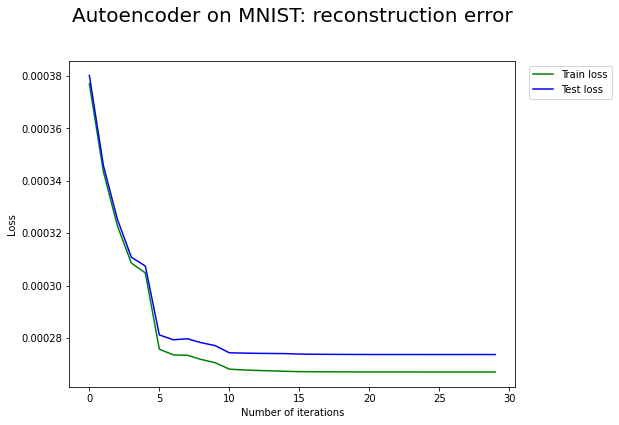

In [ ]:
plot_loss(filename=1, title="Autoencoder on MNIST: reconstruction error")

### plot 2D embeddings

After you’ve trained your model and have obtained reasonable reconstruction accuracy, obtain the 2- dimensional embeddings of a batch of images, and plot with colors indicating the label of each image.

Describe what you can learn about this dataset from looking at the points embedded into the latent space of the autoencoder.

Autoencoder's embedding of MNIST clumped each digit into separate islands, with some overlap but also large empty regions. The points in these empty parts of embedding don't correspond well to real digits, so the interpolation might be not meaningful.

In [6]:
# load trained Autoencoder
from AE import Autoencoder
model = Autoencoder()
checkpoint = torch.load("/content/gdrive/MyDrive/cpsc552 hw3/results/checkpoint1.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

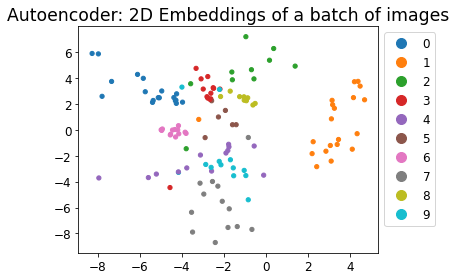

In [17]:
model.eval()
for data, targets in train_loader:
    data = data.reshape(-1, 784)

    embeddings = model.encode(data).detach().numpy()
    labels = targets.numpy()
    break
    

scprep.plot.scatter2d(embeddings, c = labels, 
                          title="Autoencoder: 2D Embeddings of a batch of images",
                          legend_anchor=(1,1))


# problem 4 VAE

## different distances

Describe the differences between Kullback-Leibler divergence, Jensen-Shannon divergence, MMD, and Wasserstein distance.

|               | symmetric | distance   | theory      |
|---------------|-----------|------------|-------------|
| TV            | Yes       | Vertical   | Probability |
| CE            | No        | Vertical   | Info theory |
| KL-divergence | No        | Vertical   | Info theory |
| JS-divergence | Yes       | Vertical   | Info theory |
| MMD           | Yes       | horizontal | Probability |
| EMD           | Yes       | horizontal | Probability |

These 4 measures are different ways of comparing 2 probability distributions.

Both KL divergence and JS divergence are divergences but not distances while both MMD and EMD are true distances which satisfy semi-positive definite, symmeric and triangle inequalty.

Both KL divergence and JS divergence are defined based on entropy of information theory, contain log damping factor to make tail discrepancy more important, while both MMD and EMD are integral probability metric

Both KL divergence and JS divergence are measured in vertical direction while both MMD and EMD are measured in ground direction.




KL divergence (relative entropy): expected number of extra bits needed if using samples from distribution P on a code optimized for distribution Q

$$
D_{\mathrm{KL}}(p \| q)=\sum_{x \in \mathcal{X}} p(x) \log \left(\frac{p(x)}{q(x)}\right).
$$

  - It's not symmetric, i.e., $D_{\mathrm{KL}}(p \| q) \neq D_{\mathrm{KL}}(q \| p)$
  
  - It's only defined if P and Q both sum to 1 and if Q(i) > 0 for any i such that P(i) > 0






- JS Divergence is like a symmetric version of KL divergence and, it's always defined and more smooth.

$$
D_{J S}(p \| q)=\frac{1}{2} D_{K L}\left(p \| \frac{p+q}{2}\right)+\frac{1}{2} D_{K L}\left(q \| \frac{p+q}{2}\right)
$$

- Maximum mean discrepancy (MMD) distance: a kernel-based 2 sample distribution test for distribution similarity, measures distance between feature means 

$$
MMD(p, q) = \frac{1}{m^2} \sum _{i, j \in m}K(p_i, p_j) - \frac{2}{mn}\sum _{i, j }K(p_i, q_j) + \frac{1}{n^2} \sum _{i, j \in n}K(q_i, q_j)
$$

where K is afinity matrix (kernel), e.g., a Gaussian kernel $K(p_i, p_j)=exp\left[\frac{{-\left\|p_i - p_j \right\|}^2}{2\sigma^2}\right]$ 

- Wasserstein distance (Earth mover's distance): EMD between 2 distributions is proportional to the minimum amount of work required to convert one distribution to the other when considering the distribution as its volume in metric space.

$$
EMD\left(p, q\right) =\sup _{\|f\|_{L \leq 1}} \mathbb{E}_{x \sim p}[f(x)]-\mathbb{E}_{y \sim q}[f(y)]
$$



in the continuous setting, the distance computed by the Kantorovich Rubenstein Duality is called Wasserstein distance
$$
\begin{aligned}W\left(p, q\right) &= \inf _{\gamma \in \pi} \iint \|x-y\| \gamma(x, y) \mathrm{d} x \mathrm{~d} y \\
&=\inf _{\gamma \in \pi} \mathbb{E}_{x, y \sim \gamma}[\|x-y\|] \\ 
\end{aligned}
$$

where $\pi$ is the set of joint distributions whose marginal distributions are $p$ and $q$.

## MNIST

Using the skeleton code in `vae.py`, fill in the TODOs to build a VAE for the MNIST dataset. 

The code returns a sample of 8 different inputs and their reconstructions for each epoch. 

Include the reconstruction sample for the first and last epoch in your report. 

Submit your filled-in version of `vae.py` along with the assignment.

KL divergence between 2 Normal distribution:

where sum is taken over each dimension in the latent space

$$
D_{KL} [N(\mu, \sigma)||N(0,1)] = \frac{1}{2}\sum (1+\log \sigma^2 - \mu^2 - \sigma^2)
$$



for additional information on computing KL divergence

see Appendix B from VAE paper: [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/abs/1312.6114)

https://github.com/pytorch/examples/issues/399

According to the original VAE paper, Binary Cross Entropy loss is used for reconstruction error because the decoder is implemented by MLP+Sigmoid which can be viewed as a 'Bernoulli distribution'. 

we can use MSE if implement a Gaussian decoder.

In [ ]:
def VAE_loss_function(recon_x, x, mu, logvar):
    # Implement reconstruction + KL divergence losses summed over all elements and batch
    recon_loss = F.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + KLD

In [ ]:
# train VAE for 100 epochs, batch size = 128, learning rate = 1e-3
!python vae.py --epochs 100 --log-interval 100

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.513977
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.929642
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.957718
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.382645
Train Epoch: 1 [51200/60000 (85%)]	Loss: 131.097824
====> Epoch: 1 Average loss: 164.4236
====> Test set loss: 127.1206
Saving checkpoint...
Train Epoch: 2 [0/60000 (0%)]	Loss: 125.521759
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.983818
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.262428
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.265854
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.208267
====> Epoch: 2 Average loss: 121.4648
====> Test set loss: 116.1533
Saving checkpoint...
Train Epoch: 3 [0/60000 (0%)]	Loss: 120.506088
Train Epoch: 3 [12800/60000 (21%)]	Loss: 113.196182
Train Epoch: 3 [25600/60000 (43%)]	Loss: 114.750771
Train Epoch: 3 [38400/60000 (64%)]	Loss: 115.177505
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.761993
====> Epoch: 3 Average loss: 114.3782
====> Test set loss

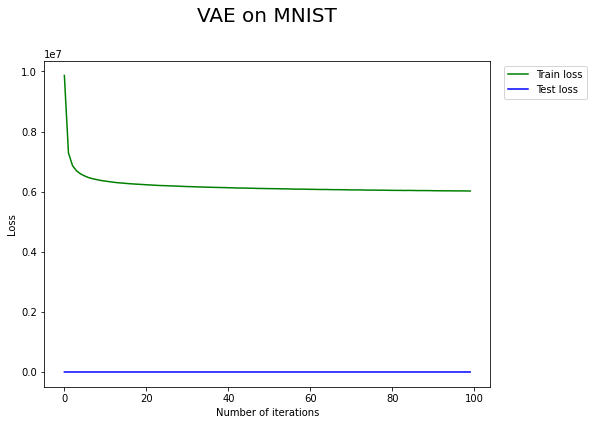

In [ ]:
plot_loss(filename=2, title="VAE on MNIST")

- plot 8 pairs of input and reconstruction samples for the first and last epoch

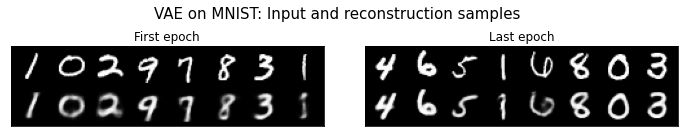

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plt.suptitle("VAE on MNIST: Input and reconstruction samples", size=15, y=0.8)
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
titles = ["First epoch", "Last epoch"]
filenames = [1, 93]
for i, filename in enumerate(filenames): 
      axes[i].imshow(plt.imread(f'./gdrive/MyDrive/cpsc552 hw3/results/reconstruction_{filename}.png'))
      axes[i].set_title(titles[i])
      axes[i].set_xticklabels([])
      axes[i].set_xticks([])
      axes[i].set_yticklabels([])
      axes[i].set_yticks([])



## Fashion MNIST

Retrain your VAE on the Fashion MNIST dataset by un-commenting lines 37-43 in `vae.py`. 

Fashion MNIST was designed as a more complex replacement for MNIST. 

Like MNIST, it contains 70,000 grayscale images of 28 by 28 pixels, 

but these are divided between ten classes of fashion accessories - sandals, handbags, pullovers 

– whose variety poses a greater challenge than handwritten digits. 

Play with the hyperparameters of your VAE to try to generate the best images possible. 

Include these in your report; 

they will be needed for comparison in Problem 5.

In [ ]:
# train VAE for 100 epochs, batch size = 128, learning rate = 1e-3
!python vae.py --epochs 100 --log-interval 100

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.565063
Train Epoch: 1 [12800/60000 (21%)]	Loss: 285.834595
Train Epoch: 1 [25600/60000 (43%)]	Loss: 273.949677
Train Epoch: 1 [38400/60000 (64%)]	Loss: 276.660980
Train Epoch: 1 [51200/60000 (85%)]	Loss: 272.629852
====> Epoch: 1 Average loss: 285.4404
====> Test set loss: 262.8914
Saving checkpoint...
Train Epoch: 2 [0/60000 (0%)]	Loss: 258.373413
Train Epoch: 2 [12800/60000 (21%)]	Loss: 268.959412
Train Epoch: 2 [25600/60000 (43%)]	Loss: 265.395172
Train Epoch: 2 [38400/60000 (64%)]	Loss: 245.583862
Train Epoch: 2 [51200/60000 (85%)]	Loss: 238.896149
====> Epoch: 2 Average loss: 256.0104
====> Test set loss: 253.9486
Saving checkpoint...
Train Epoch: 3 [0/60000 (0%)]	Loss: 254.239944
Train Epoch: 3 [12800/60000 (21%)]	Loss: 252.622925
Train Epoch: 3 [25600/60000 (43%)]	Loss: 238.936630
Train Epoch: 3 [38400/60000 (64%)]	Loss: 242.676010
Train Epoch: 3 [51200/60000 (85%)]	Loss: 246.409119
====> Epoch: 3 Average loss: 250.2096
====> Test set loss

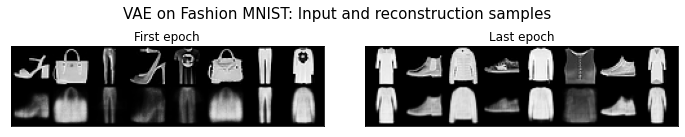

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plt.suptitle("VAE on Fashion MNIST: Input and reconstruction samples", size=15, y=0.8)
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
titles = ["First epoch", "Last epoch"]
filenames = [1, 88]
for i, filename in enumerate(filenames): 
      axes[i].imshow(plt.imread(f'./gdrive/MyDrive/cpsc552 hw3/results/FashionMNIST/reconstruction_{filename}.png'))
      axes[i].set_title(titles[i])
      axes[i].set_xticklabels([])
      axes[i].set_xticks([])
      axes[i].set_yticklabels([])
      axes[i].set_yticks([])

# problem 5 GAN

## implement GAN

implement GAN in `gan.py`

generator and discriminator have separate classes and training functions

## Fashion MNIST

Run your GAN on the Fashion MNIST dataset.

Note: this will take 10-30 minutes or longer if your computer lacks an NVIDIA GPU. 

Google COLAB provides free GPU enabled runtimes, and could be a good resource.

In [ ]:
!python GAN.py

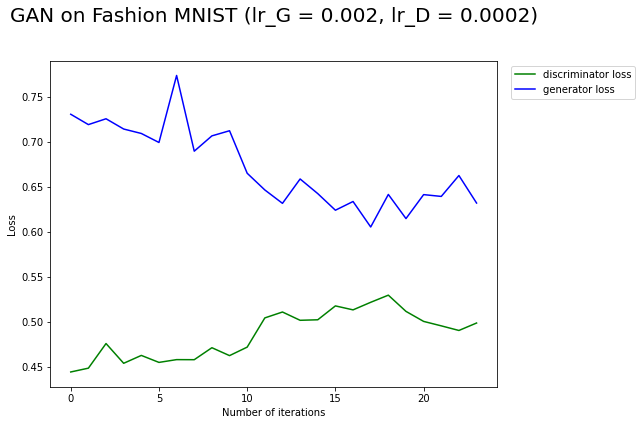

In [33]:
plot_loss(filename=1, title="GAN on Fashion MNIST (lr_G = 0.002, lr_D = 0.0002)")

## hyperparameters tuning

Experiment with the hyperparameters of your GAN to try to produce the best-quality images possible. 

What happens if you use different **learning rates** for the discriminator and generator, 

or if you train the generator multiple times for every iteration of the discriminator? 

Describe the best training scheme, and any problems you encountered during training. 

Include sample generations in your report.

- best training scheme: number of epochs = 24, learning rate generator = 0.0002, discriminator = 0.0002, batch_size = 64

- training 1: number of epochs = 24, learning rate generator = 0.0002, discriminator = 0.0002, batch_size = 64

- training2: number of epochs = 24, learning rate generator = 0.002, discriminator = 0.0002, batch_size = 64

- training3: number of epochs = 24, learning rate generator = 0.0002, discriminator = 0.002, batch_size = 64

- training4: train generator 2 times for every iteration of discriminator 
number of epochs = 24, learning rate generator = 0.0002, discriminator = 0.0002, batch_size = 64

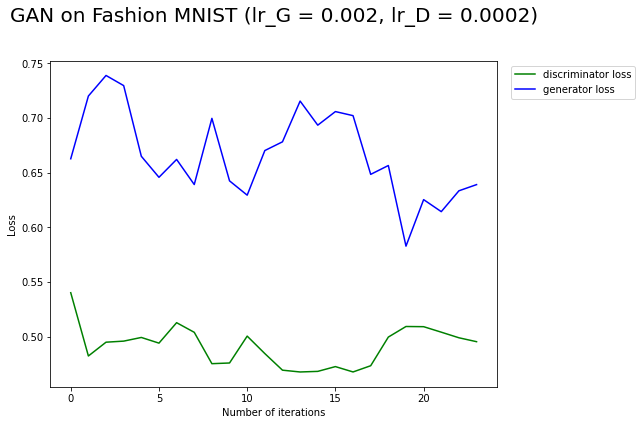

In [ ]:
plot_loss(filename=2, title="GAN on Fashion MNIST (lr_G = 0.002, lr_D = 0.0002)")

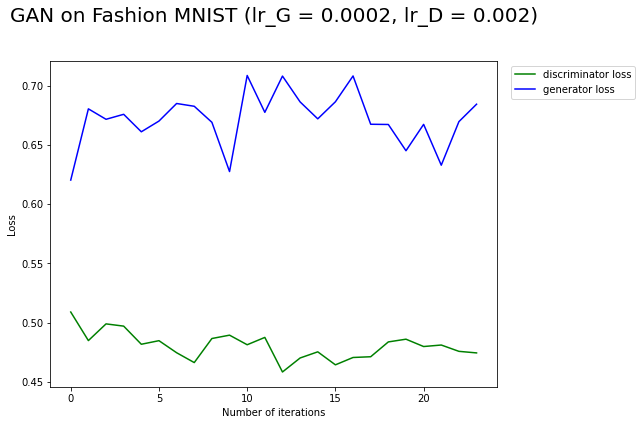

In [ ]:
plot_loss(filename=3, title="GAN on Fashion MNIST (lr_G = 0.0002, lr_D = 0.002)")

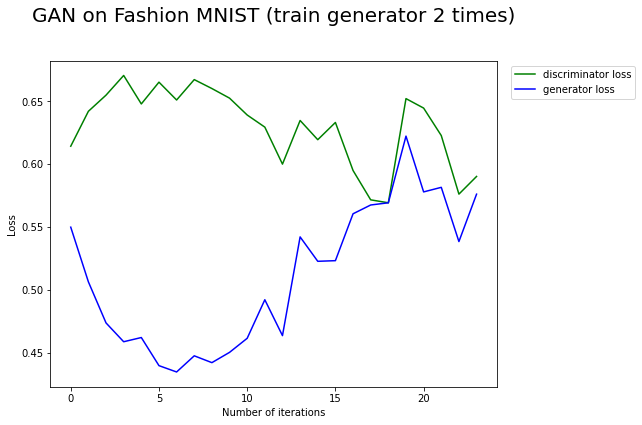

In [ ]:
plot_loss(filename=4, title="GAN on Fashion MNIST (train generator 2 times)")

## Conditional GAN

- implement conditional GAN in `cGAN.py` 

- standard GAN is an unsupervised model, cGAN is semi-supervised model

    Conditional GAN provides the generator and discriminator with image **labels**. 

    This allows a Conditional GAN to generate images from **a specific class** on demand,

    and enables the discriminator to penalize generated images which deviate from their labels. 

Run your Conditional GAN on Fashion MNIST. 

How do these generated images compare to your initial GAN, in quality and abundance of each class?

- The quality of cGAN generated images is worse than initial GAN, I can see some transitions between different classes, but the abundance of each class is increase, initial GAN generated images are almost T-shirt/top, Trouser or Pullover, while cGAN generated more bags and shoes.

In [ ]:
!python cGAN.py 

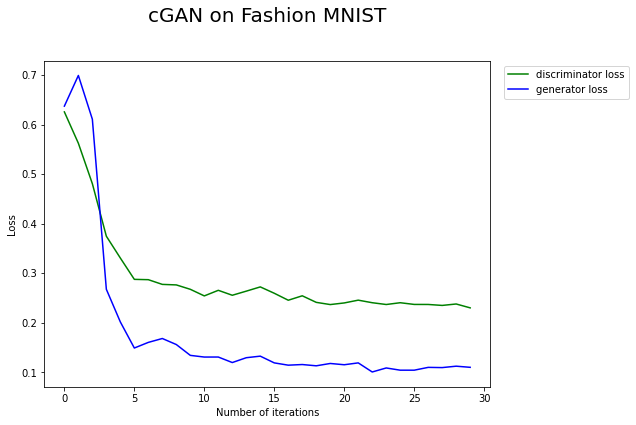

In [54]:
plot_loss(filename=1, title="cGAN on Fashion MNIST")

## GAN VS. VAE

Describe the theoretical differences between a generative adversarial network (GAN) and a variational autoencoder (VAE). 

What differences did you notice in practice? 

What tasks would be more suited for a VAE, and what tasks require a GAN?

- theoretical difference: 

  architecture: GAN has 2 components of neural network: a discriminator and a generator; VAE also has 2 components of neural network: an encoder and a decoder.

  loss function: 
  
  GAN: plays a min-max two-player game, loss is standard cross-entropy loss with 2 terms, first term ensures generator generates the image as much closer to the true image as possible to fool the discriminator, via **maximizing the cross-entropy loss**, the second term motivates discriminator to distinguish the generated images from the true images, via **minimizing the cross-entropy loss**

  $$
  \min_G \max_D L(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(x))]
  $$ 
  
  VAE: reconstruction loss + KL divergence

$$
L(\theta, \phi) = -\mathbb{E}_{z \sim q_{\theta}(z|x)} [\log p_{\phi} (x_i|z)] + KL [q_{\theta}(z|x)|| p(z)]
$$

- practical difference: GANs are more hard to train, which requires a lot of data and training in terms of choosing learning rate for generator and discriminator respectively. GAN outputs sharp images while VAE outputs blurry images. Given an X, GAN is hard to find z while VAE is easy to find z. VAE has interpretable probability P(X) while GAN has no explicit P(X)


- suitable tasks: VAE for easy generation of z given X (imsages are blurry), GAN for generating sharp images given z

  generate human faces, generate realistic photographs (BigGAN), generate cartoon characters, image-to-image translation (CycleGAN), text-to-image translation (StackGAN), semantic-image-to-photo translation (TAC-GAN), face frontal view generation, generate new human poses, photos to emojis, photograph editing (IcGAN), face aging, photo blending (GP-GAN), super resolution (SRGAN), photo inpainting, clothing translation, vidwo prediction, 3D object generation


- References: 

  https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

  https://towardsdatascience.com/gans-vs-autoencoders-comparison-of-deep-generative-models-985cf15936ea

  https://slazebni.cs.illinois.edu/spring17/lec12_vae.pdf

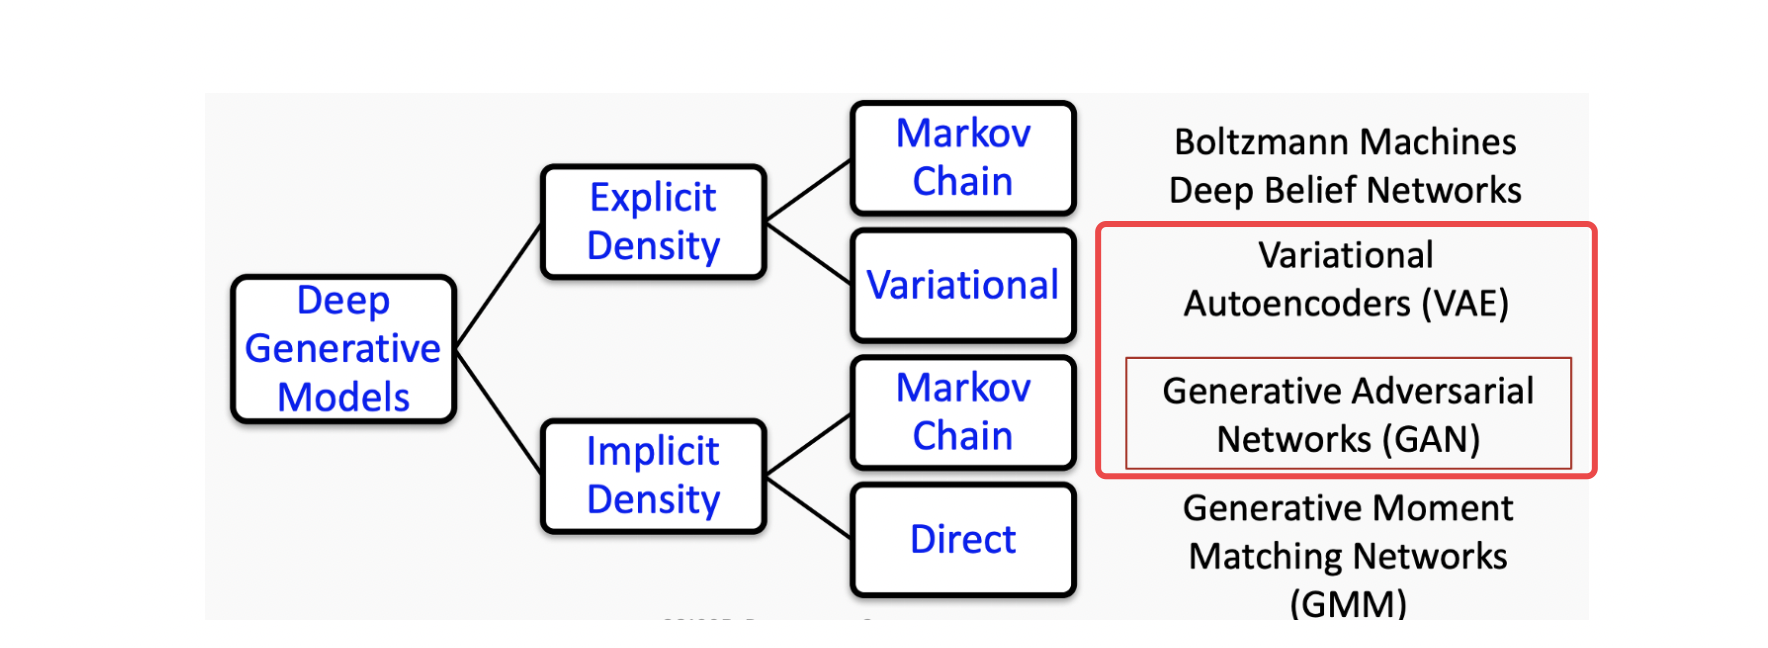

## input distribution to be Gaussian

Why do we often choose the input $z$ to a GAN to be samples from a Gaussian? 

Can you think of any potential problems with this?

reason: mathmetical simplicity and central limit theorem

problems: if the true data distribution isn't close to Gaussian, e.g., the decay of drug density more fits the Poission distribution, the model might be underfitting.

## DiscoGAN, CycleGAN: mapping from one domain to another

Domain transfer: mapping from one domain to another (e.g. faces with black hair to faces with blond hair). 

A simple model for this would learn two generators: one that takes the first domain as input and produces output in the second domain as judged by a discriminator, and vice versa for the other domain. 

What are reasons DiscoGAN/CycleGAN perform better at this task than simpler model?

- They share weight, which reduce number of weights to train, make optimization easier, indirectly increase number of training samples and generalizability.